In [1]:
import torchvision
print(torchvision.__version__)


0.21.0+cu124


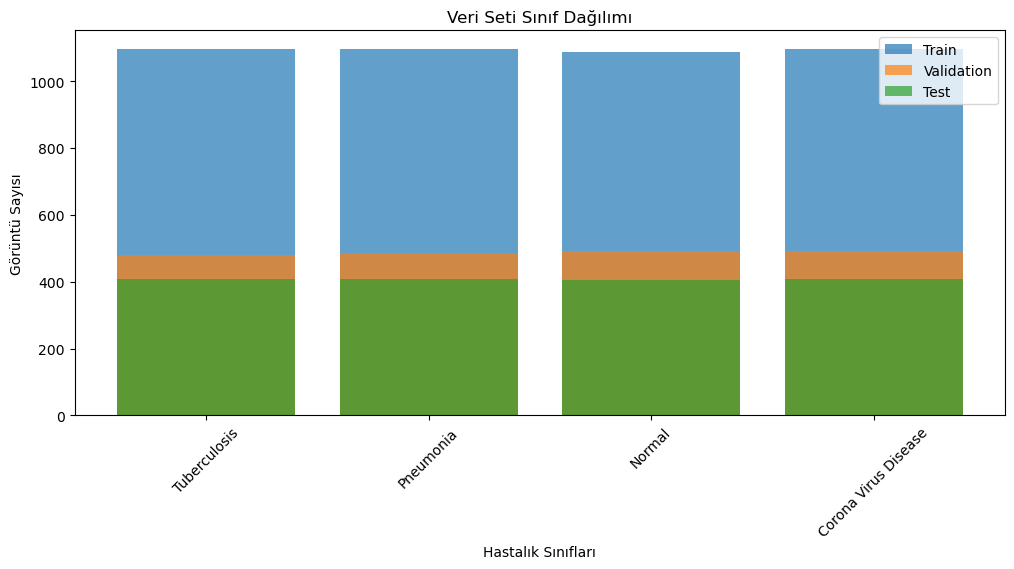

In [2]:
import matplotlib.pyplot as plt
import os

data_paths = {
    "Train": "/home/omerc/IKT450/Proje/LungXRays-grayscale/train",
    "Validation": "/home/omerc/IKT450/Proje/LungXRays-grayscale/val",
    "Test": "/home/omerc/IKT450/Proje/LungXRays-grayscale/test",
}

# Her veri setindeki sınıf sayılarını hesaplayalım
class_counts = {split: {cls: len(os.listdir(os.path.join(path, cls))) 
                        for cls in os.listdir(path)} 
                for split, path in data_paths.items()}

# Görselleştirme
plt.figure(figsize=(12, 5))
for split, counts in class_counts.items():
    plt.bar(counts.keys(), counts.values(), alpha=0.7, label=split)

plt.xlabel("Hastalık Sınıfları")
plt.ylabel("Görüntü Sayısı")
plt.title("Veri Seti Sınıf Dağılımı")
plt.legend()
plt.xticks(rotation=45)
plt.show()


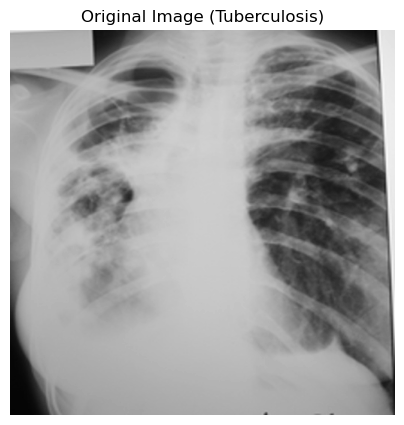

Selected Image: /home/omerc/IKT450/Proje/LungXRays-grayscale/train/Tuberculosis/533.jpg


In [26]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Define the training directory path
train_dir = "/home/omerc/IKT450/Proje/LungXRays-grayscale/train"

# Select the first class (subdirectory) in the training directory
first_class = os.listdir(train_dir)[0]
class_path = os.path.join(train_dir, first_class)

# Select the first image in the chosen class directory
image_name = os.listdir(class_path)[0]
image_path = os.path.join(class_path, image_name)

# Open the image
image = Image.open(image_path)

# Display the original image
plt.figure(figsize=(5, 5)) 
plt.imshow(image, cmap="gray") 
plt.title(f"Original Image ({first_class})")
plt.axis("off") 
plt.show() 

# Print the path of the selected image
print(f"Selected Image: {image_path}")

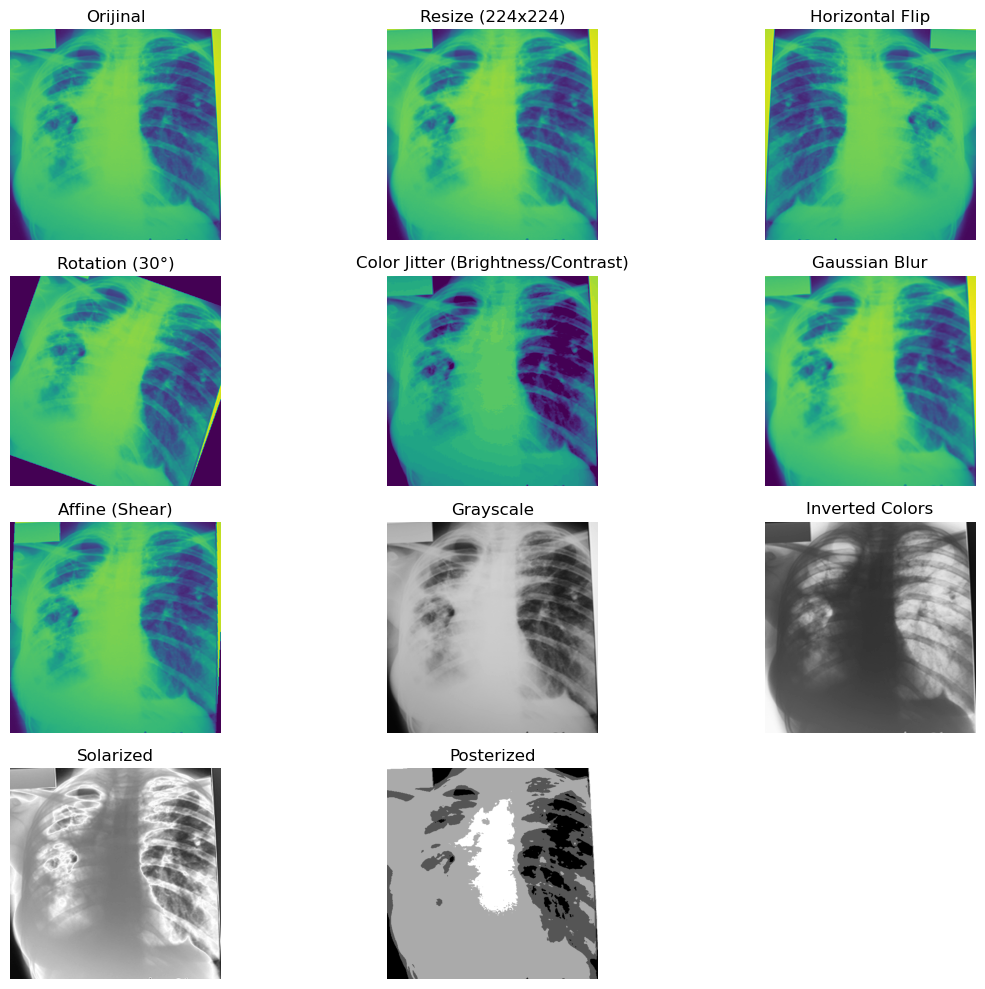

In [4]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

# Veri seti yolunu ayarla
train_dir = "/home/omerc/IKT450/Proje/LungXRays-grayscale/train"

# İlk sınıfı seç
first_class = os.listdir(train_dir)[0]
class_path = os.path.join(train_dir, first_class)

# İlk resmi seç
image_name = os.listdir(class_path)[0]
image_path = os.path.join(class_path, image_name)

# Görüntüyü aç
image = Image.open(image_path)

# Farklı transformları tanımlayalım (Çeşitlendirilmiş renk efektleri ile)
transformations = {
    "Orijinal": transforms.Compose([]),
    "Resize (224x224)": transforms.Compose([transforms.Resize((224, 224))]),
    "Horizontal Flip": transforms.Compose([transforms.RandomHorizontalFlip(p=1)]),
    "Rotation (30°)": transforms.Compose([transforms.RandomRotation(30)]),
    "Color Jitter (Brightness/Contrast)": transforms.Compose([transforms.ColorJitter(brightness=0.8, contrast=0.8)]),
    "Gaussian Blur": transforms.Compose([transforms.GaussianBlur(kernel_size=5)]),
    "Affine (Shear)": transforms.Compose([transforms.RandomAffine(degrees=0, shear=20)]),
    "Grayscale": transforms.Compose([transforms.Grayscale(num_output_channels=1)]),
    "Inverted Colors": transforms.Compose([transforms.RandomInvert(p=1)]),
    "Solarized": transforms.Compose([transforms.RandomSolarize(threshold=128, p=1)]),
    "Posterized": transforms.Compose([transforms.RandomPosterize(bits=2, p=1)]),
}

# Görüntüleri gösterme
plt.figure(figsize=(12, 10))

for i, (name, transform) in enumerate(transformations.items()):
    if transform.transforms:  # Eğer bir transform varsa uygula
        transformed_image = transform(image)
    else:
        transformed_image = image

    plt.subplot(4, 3, i + 1)
    if name in ["Grayscale", "Inverted Colors", "Solarized", "Posterized"]:
        plt.imshow(transformed_image, cmap="gray")
    else:
        plt.imshow(transformed_image)
    plt.title(name)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models  # ResNet18 için models eklendi
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import os
import sys
import time

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU Model: {torch.cuda.get_device_name(0)}")
    print(f"GPU Sayısı: {torch.cuda.device_count()}")

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG16 224x224 bekler
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # RGB için 3 kanal normalizasyon
])

Using device: cpu


In [7]:
DATASET_PATH = "/home/omerc/IKT450/Proje/LungXRays-grayscale"
train_dataset = datasets.ImageFolder(os.path.join(DATASET_PATH, "train"), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(DATASET_PATH, "val"), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(DATASET_PATH, "test"), transform=transform)

print(f'train: {len(train_dataset)}')
print(f'val: {len(val_dataset)}')
print(f'test: {len(test_dataset)}')

BATCH_SIZE = 64  
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)


train: 4378
val: 1948
test: 1625


In [8]:
import timm
print(timm.__version__)


1.0.15


In [9]:
# EfficientNet Model
class EfficientNetModel(nn.Module):
    def __init__(self, num_classes=4):
        super(EfficientNetModel, self).__init__()
        self.model = timm.create_model('efficientnet_b0', pretrained=True)
        self.model.classifier = nn.Linear(self.model.classifier.in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

num_classes = len(train_dataset.classes)  # Sınıf sayısını al
model = EfficientNetModel(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [10]:
# Early Stopping 
class EarlyStopping:
    def __init__(self, patience=5, delta=0, path='best_model.pt'):
        self.patience = patience
        self.path = path
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            torch.save(model.state_dict(), self.path)
            self.counter = 0
        else:
            self.counter += 1
            print(f'Early stopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

In [11]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    learning_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        learning_loss += loss.item()
        _, predict = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predict == labels).sum().item()
    learning_loss_result = learning_loss / total if total > 0 else 0
    train_acc = 100 * correct / total if total > 0 else 0
    return learning_loss_result, train_acc

In [12]:
def validation(model, val_loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predict = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predict == labels).sum().item()
    result_running_loss = running_loss / total if total > 0 else 0
    result_val_acc = 100 * correct / total if total > 0 else 0
    return result_running_loss, result_val_acc

In [13]:
num_epoch = 10
earlyStopping = EarlyStopping(patience=5, path='checkpoint.pt')
start_time = time.time()
train_losses, train_accs, val_losses, val_accs = [], [], [],[]

for epoch in range(num_epoch):
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validation(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f'Epoch {epoch+1}/{num_epoch}: Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    sys.stdout.flush()
    earlyStopping(val_loss, model)
    if earlyStopping.early_stop:
        print('Note: Early stopping triggered, stopping training.')
        break
end_time = time.time()
print(f'Training Time: {end_time - start_time:.2f} seconds')

Epoch 1/10: Train Loss: 0.0034 Train Acc: 92.1425, Val Loss: 0.0022, Val Acc: 95.0719
Epoch 2/10: Train Loss: 0.0012 Train Acc: 97.2590, Val Loss: 0.0014, Val Acc: 97.4333
Epoch 3/10: Train Loss: 0.0008 Train Acc: 98.3326, Val Loss: 0.0020, Val Acc: 96.0986
Early stopping counter: 1 out of 5
Epoch 4/10: Train Loss: 0.0005 Train Acc: 99.0863, Val Loss: 0.0021, Val Acc: 95.9446
Early stopping counter: 2 out of 5
Epoch 5/10: Train Loss: 0.0006 Train Acc: 98.7437, Val Loss: 0.0012, Val Acc: 97.3306
Epoch 6/10: Train Loss: 0.0005 Train Acc: 98.9493, Val Loss: 0.0017, Val Acc: 97.0739
Early stopping counter: 1 out of 5
Epoch 7/10: Train Loss: 0.0005 Train Acc: 98.7894, Val Loss: 0.0040, Val Acc: 95.1745
Early stopping counter: 2 out of 5
Epoch 8/10: Train Loss: 0.0003 Train Acc: 99.2919, Val Loss: 0.0050, Val Acc: 92.9158
Early stopping counter: 3 out of 5
Epoch 9/10: Train Loss: 0.0004 Train Acc: 99.1549, Val Loss: 0.0012, Val Acc: 97.3306
Early stopping counter: 4 out of 5
Epoch 10/10: Tra

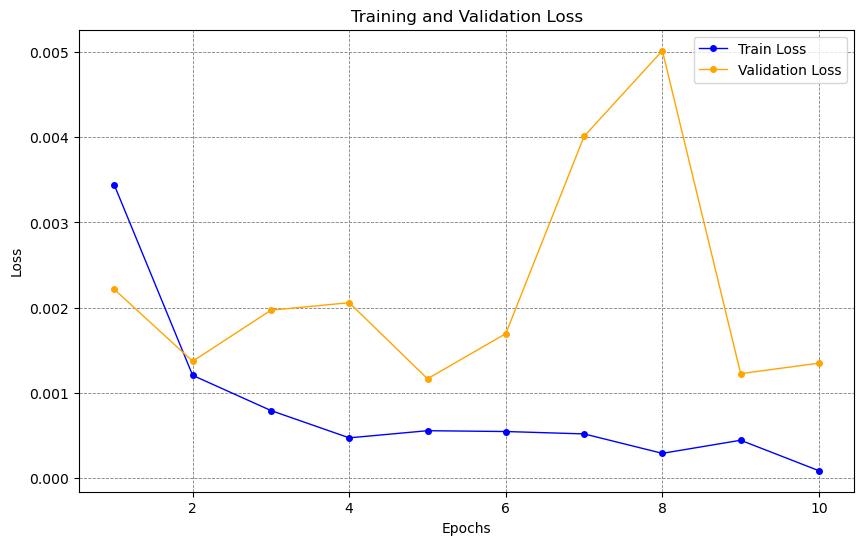

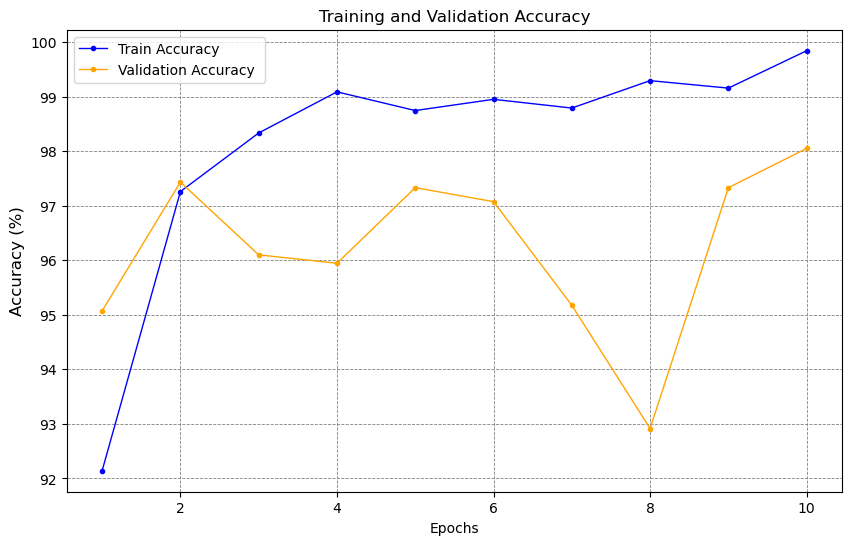

In [19]:
def Plot_metrics(train_losses, val_losses, train_accs, val_accs):
    epoch = range(1, len(train_losses)+1)
    plt.figure(figsize=(10, 6))
    plt.plot(epoch, train_losses, label= 'Train Loss', color = 'blue',  marker='o', markersize=4, linestyle='-', linewidth=1)
    plt.plot(epoch, val_losses, label='Validation Loss', color='orange',  marker='o', markersize=4, linestyle='-', linewidth=1)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.grid(True, which='both', linestyle='--', linewidth=0.6, color='gray')
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(epoch, train_accs, label= 'Train Accuracy ', color = 'blue',  marker='o', markersize=3, linestyle='-', linewidth=1)
    plt.plot(epoch, val_accs, label='Validation Accuracy ', color='orange',  marker='o', markersize=3, linestyle='-', linewidth=1)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.title('Training and Validation Accuracy')
    plt.grid(True, which='both', linestyle='--', linewidth=0.6, color='gray')
    plt.show()

Plot_metrics(train_losses, val_losses, train_accs, val_accs)

In [20]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predict = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predict == labels).sum().item()
            all_preds.extend(predict.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    avg_test_loss = test_loss / total if total > 0 else 0
    test_acc = 100 * correct / total if total > 0 else 0
    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.4f}%')
    return avg_test_loss, test_acc

evaluate_model(model, test_loader, criterion, device)

Test Loss: 0.0011, Test Accuracy: 98.2154%


(0.0010678883346487195, 98.21538461538462)

In [21]:
# Classification Report 
from sklearn.metrics import  classification_report

def classification_report_test(model, data_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

classification_report_test(model, test_loader, train_dataset.classes)

Classification Report:
                      precision    recall  f1-score   support

Corona Virus Disease       0.98      1.00      0.99       407
              Normal       0.98      0.97      0.97       404
           Pneumonia       0.97      0.97      0.97       407
        Tuberculosis       1.00      1.00      1.00       407

            accuracy                           0.98      1625
           macro avg       0.98      0.98      0.98      1625
        weighted avg       0.98      0.98      0.98      1625



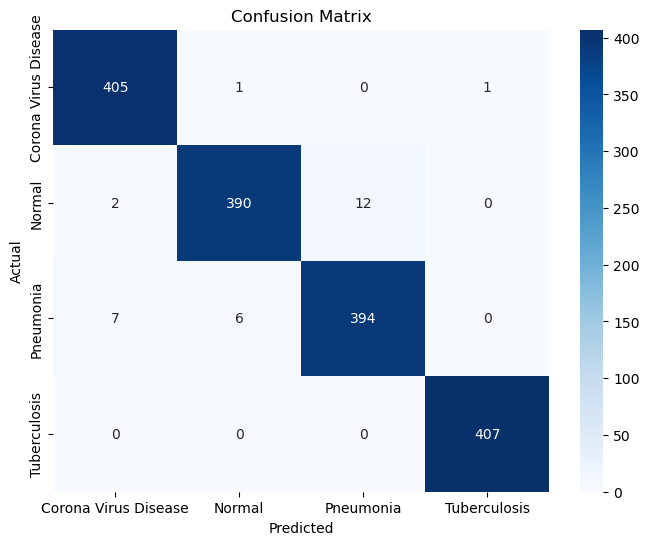

In [22]:
# Confusion Matrix 
def plot_confusion_matrix(model, data_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
plot_confusion_matrix(model, test_loader, train_dataset.classes)


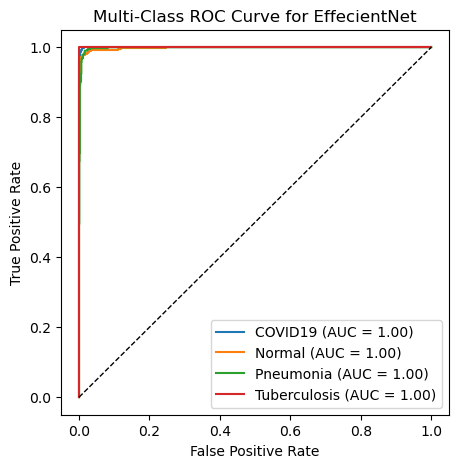

In [25]:
def plot_auc_curve(model, data_loader, class_labels):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    
    plt.figure(figsize=(5, 5))
    for i, label in enumerate(class_labels):
        fpr, tpr, _ = roc_curve(all_labels == i, all_probs[:, i])
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {auc_score:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)  # Diagonal line for reference
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curve for EffecientNet')
    plt.legend()
    plt.show()

# Örnek sınıf etiketleri
target_labels = ['COVID19', 'Normal', 'Pneumonia', 'Tuberculosis']
plot_auc_curve(model, test_loader, target_labels)